<a href="https://colab.research.google.com/github/khazzan/toolwearID/blob/main/Tool_Wear_Detection3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#@title Import packages and libraries
!pip install -q tflite-model-maker
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!git clone https://github.com/khazzan/toolwearID.git

import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
fatal: destination path 'toolwearID' already exists and is not an empty directory.


In [14]:
dataset_is_split = True
use_custom_dataset = True
if not use_custom_dataset:
  train_data, validation_data, test_data = object_detector.DataLoader.from_csv('wear_ml_use2.csv')
label_map = {1: 'flank_wear'} 

train_images_dir = 'toolwearID/split-dataset2/train/images'
train_annotations_dir = 'toolwearID/split-dataset2/train/annotations'
val_images_dir = 'toolwearID/split-dataset2/validation/images'
val_annotations_dir = 'toolwearID/split-dataset2/validation/annotations'
test_images_dir = 'toolwearID/split-dataset2/test/images'
test_annotations_dir = 'toolwearID/split-dataset2/test/annotations'

train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)

In [15]:
import random
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0, len(filenames) -1)
!python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/


In [16]:
#@title Default title text
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

!python3 -m pip install tflite-runtime
!pip install tflite-support
import tflite_runtime.interpreter as tflite 


from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size = (len(labels), 3), dtype = np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline = color, width = 3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size = 15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill = color, font = font)

# Load the TF Lite model

LABELS_FILENAME = 'toolwearID/tf-lite_model2/wear-labels2.txt'
TFLITE_FILENAME = 'toolwearID/tf-lite_model2/efficientdet-lite-wear2.tflite'

labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


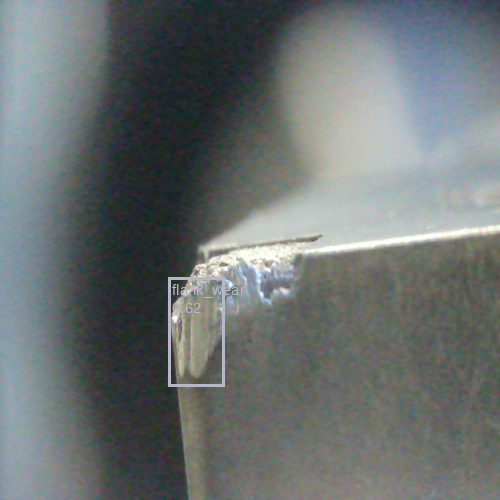

In [17]:
INPUT_IMAGE = os.path.join(images_path, filenames[24])
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.4, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
if (objs != 0):
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
else:
  image = image
image

In [18]:
print(objs)
ratio = 0.00771 # 441px = 3.341mm
if (len(objs) == 0):
  wear_edge = 0
  vb_max = wear_edge
else:
  for x in range(len(objs)):
    wear_edge = "{:.2f}".format(((objs[x][2][2]) - (objs[x][2][0])) * ratio)
    vb_max = "{:.2f}".format(((objs[x][2][3]) - (objs[x][2][1])) * ratio)
    print("wear_edge_" + str(x) + ": " + str(wear_edge) + " mm")
    print("vb_max_" + str(x) + ": " +str(vb_max) + " mm")

# [rows, columns]
# crop = img[50:180, 100:300] 

[Object(id=0, score=0.625, bbox=BBox(xmin=345, ymin=569, xmax=459, ymax=791))]
wear_edge_0: 0.88 mm
vb_max_0: 1.71 mm


### Insitu images

In [19]:
insitu_images_dir = 'toolwearID/insitu-dataset'

insitu_filenames = os.listdir(os.path.join(insitu_images_dir))
random_index = random.randint(0, len(insitu_filenames) -1)


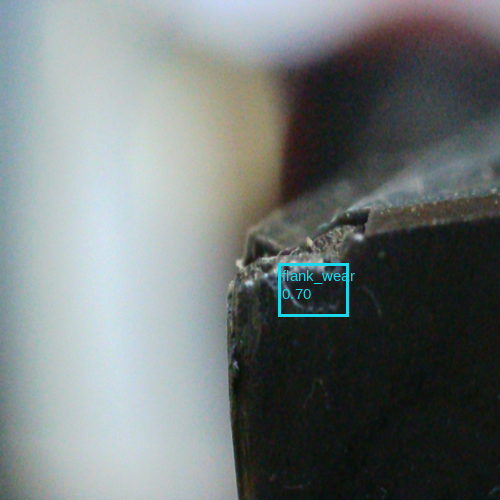

In [36]:
TESTING_IMAGE = os.path.join(insitu_images_dir, insitu_filenames[80])
image = Image.open(TESTING_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.4, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
if (objs != 0):
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
else:
  image = image
image

In [37]:
print(objs)
ratio = 0.00771 # 441px = 3.341mm
if (len(objs) == 0):
  wear_edge = 0
  vb_max = wear_edge
else:
  for x in range(len(objs)):
    wear_edge = "{:.2f}".format(((objs[x][2][2]) - (objs[x][2][0])) * ratio)
    vb_max = "{:.2f}".format(((objs[x][2][3]) - (objs[x][2][1])) * ratio)
    print("wear_edge_" + str(x) + ": " + str(wear_edge) + " mm")
    print("vb_max_" + str(x) + ": " +str(vb_max) + " mm")

[Object(id=0, score=0.69921875, bbox=BBox(xmin=570, ymin=539, xmax=714, ymax=649))]
wear_edge_0: 1.11 mm
vb_max_0: 0.85 mm


In [38]:
#Once the wear measurement has retrieve use that to inform the decision
#Function for tool reconditioning method should use the wear_edge and vb_max values
#if 2 or more regions are there sum the max value of each
# input tool shape and if chip breaker
#Parameters list for each in order = [%, kHz, mm/s, mm]

plg = [[85, 100, 750, 0.01], [100, 150, 50, 0.05]]
plm = [[70, 70, 1000, 0.01], [100, 100, 50, 0.01]]
plr = [85, 70, 1000, 0.01]
pln = [100, 100, 20, 0.005]
plp = [100, 200, 10, 0.005]

def reconSelection(a, b, c):
  #a relates to wear_edge
  #b realtes to vb_max
  a = float(a)
  b = float(b)
  if ((a < 0.3) and (b < 0.2)):
    print("no need to recondition")
  elif (((b >= 0.2) and (b < 0.4)) and (a < 0.5)) or ((b < 0.2) and ((a >= 0.3) and (a < 1.5))):
    print("plg option chosen")
  elif (((b >= 0.2) and (b < 0.6)) and (a > 0.5)):
    print("plm option chosen")
  elif ((b >= 0.6) and (b < 1.25)) or (((b >= 0.4) and (b < 0.6)) and (a < 0.5)):
    print("plr option chosen")


  #d is if there is a chip breaker
  if (c == 1):
    print("need additional step pln + add extra lasr code to compensate")
  else:
    print("keep initial code")
  return  


reconSelection(wear_edge, vb_max, 0)



plr option chosen
keep initial code


In [43]:
import numpy as np
import os
import math
import textwrap
import datetime


# Variables and Arrays =================================================
ProcessCode = ['G1 ', 'G0 ', 'G3 ']
MotionCode = ['ENABLE ', 'HOME ', 'RAPID ', 'REPEAT ', 'END REPEAT']
Mcodes = ['M2 ', 'M30 ', 'M46 ', 'M47 ']
Variables = ['$task[1]', '$task[2]', '$task[3]', '$task[4]']
LaserState = 0
ToolState = 0
LaserOn = ''' $DO [2].Z = 0
    DWELL .1
 $DO [1].Z = 1
     DWELL .1 \n'''
LaserOff = ''' $DO [1].Z = 0
    DWELL .1
 $DO [2].Z = 1
     DWELL .1 \n'''

ZeroOut = '''$WO[0].Z = 0
DWELL .1'''
axis3 = 'X Y Z' 

filename = datetime.datetime.now()
info = ''
indent = '     '
indent2 = '          '
Counter = 0
coord = ['Z', 'X', 'Y', 'U']
coordVal = []
start = [] 
startVal = []

plg = [[85, 100, 750, 0.01], [100, 150, 50, 0.05]]
plm = [[70, 70, 1000, 0.01], [100, 100, 50, 0.01]]
plr = [85, 70, 1000, 0.01]
pln = [100, 100, 20, 0.005]
plp = [100, 200, 10, 0.005]


def axisConfig(x):
  global axistext
  global endtext
  axistext = ZeroOut + '\n' + (MotionCode[0] + axis3) +'\n'+ (MotionCode[1] + axis3) +'\n'+ 'INCREMENTAL'
  endtext = (MotionCode[1] + axis3) +'\n' + ZeroOut + '\n' + '\n' + Mcodes[1]


def startCoord(x):
    global start
    global startVal
    startVal = [coord[0]+coordVal[0], coord[1]+coordVal[1],coord[2]+coordVal[2]]
    start = ProcessCode[0] + (startVal[0]+' '+ startVal[1]+' '+ startVal[2])

    return (startVal)

def reconSelection(a, b, c):
  #a relates to wear_edge
  #b realtes to vb_max
  a = float(a)
  b = float(b)
  if ((a < 0.3) and (b < 0.2)):
    print("no need to recondition")
  elif (((b >= 0.2) and (b < 0.4)) and (a < 0.5)) or ((b < 0.2) and ((a >= 0.3) and (a < 1.5))):
    print("plg option chosen")
  elif (((b >= 0.2) and (b < 0.6)) and (a > 0.5)):
    print("plm option chosen")
  elif ((b >= 0.6) and (b < 1.25)) or (((b >= 0.4) and (b < 0.6)) and (a < 0.5)):
    print("plr option chosen")


  #d is if there is a chip breaker
  if (c == 1):
    print("need additional step pln + add extra lasr code to compensate")
  else:
    print("keep initial code")
  return  

with open('laser_gcode.txt', 'w') as f:
  f.write("hello")



reconSelection(wear_edge, vb_max, 0)